# Analyze Soldier Depictions over time

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, spearmanr
from dotenv import load_dotenv


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# from util import get_keyframe_paths

In [2]:
load_dotenv()

CHAPTERS_DATA_TSV = Path(os.getenv("CHAPTERS_DATA_TSV")).resolve()
CONTENT_CLASSIFICATIONS_DIR = Path(os.getenv("CONTENT_CLASSIFICATIONS_DIR")).resolve()
individual = "individual"
collective = "collective"
multiples = "multiples"

In [3]:
def get_depiction_ratio(row: pd.Series, depiction: str) -> float | None:
    filename = row["filestem"] + "_" + row["chapter"] + ".csv"
    path = CONTENT_CLASSIFICATIONS_DIR / filename
    if not path.is_file():
        return None
    try: 
        df = pd.read_csv(path)
        n = len(df[(df["prediction"] == individual) | (df["prediction"] == collective) | (df["prediction"] == multiples)])
        if n == 0:
            return None
        shots = len(df[df["prediction"] == depiction])
        return shots / n
    except Exception as e:
        print(e)
        return None

In [4]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Only data with timestamps
df = df[(df["start"].notna()) & (df["end"].notna())]
len(df)

2369

In [5]:
DF_COMBAT = df[(df["is_combat_scene"].notna()) & (df["is_combat_scene"])]
DF_WAR_REPORT = df[(df["is_war_report"].notna()) & (df["is_war_report"])]
DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]

In [6]:
df_description = "flagged as soldier depiction scenes"
df = DF_SOLDIERS

print(f"Data size: {len(df)}")

df["individual_ratio"] = df.apply(lambda row: get_depiction_ratio(row, individual), axis=1)
df["collective_ratio"] = df.apply(lambda row: get_depiction_ratio(row, collective), axis=1)
df["multiples_ratio"] = df.apply(lambda row: get_depiction_ratio(row, multiples), axis=1)

Data size: 1503


In [7]:
df = df[df["individual_ratio"].notna()]

In [8]:
df["individual_ratio"].describe()

count    1443.000000
mean        0.251284
std         0.206945
min         0.000000
25%         0.100000
50%         0.230769
75%         0.363636
max         1.000000
Name: individual_ratio, dtype: float64

In [9]:
df["collective_ratio"].describe()

count    1443.000000
mean        0.294394
std         0.283855
min         0.000000
25%         0.052632
50%         0.200000
75%         0.500000
max         1.000000
Name: collective_ratio, dtype: float64

In [10]:
df["multiples_ratio"].describe()

count    1443.000000
mean        0.454322
std         0.271081
min         0.000000
25%         0.250000
50%         0.488889
75%         0.642857
max         1.000000
Name: multiples_ratio, dtype: float64

In [11]:
# Compute mean ratios per episode
episode_stats = df.groupby(['year', 'episode']).agg({
    'individual_ratio': 'mean',
    'multiples_ratio': 'mean',
    'collective_ratio': 'mean'
}).reset_index()

In [12]:
episode_stats

,year,episode,individual_ratio,multiples_ratio,collective_ratio
0,1940,511,0.124423,0.465399,0.410179
1,1940,512,0.096476,0.454926,0.448598
2,1940,513,0.218670,0.329006,0.452324
3,1940,515,0.312303,0.363193,0.324504
4,1940,517,0.278125,0.323958,0.397917
...,...,...,...,...,...
210,1944,744,0.430760,0.469240,0.100000
211,1944,745,0.767618,0.146618,0.085765
212,1944,746,0.400656,0.563282,0.036062
213,1945,747,0.317216,0.539560,0.143223


In [13]:
year_stats = episode_stats.groupby('year').agg({
    'individual_ratio': 'mean',
    'multiples_ratio': 'mean',
    'collective_ratio': 'mean'
}).reset_index()

In [14]:
year_stats

,year,individual_ratio,multiples_ratio,collective_ratio
0,1940,0.213433,0.420697,0.365870
1,1941,0.214087,0.466628,0.319285
2,1942,0.211710,0.455075,0.333214
3,1943,0.270339,0.448053,0.281608
4,1944,0.337331,0.426339,0.236330
5,1945,0.384485,0.428991,0.186524


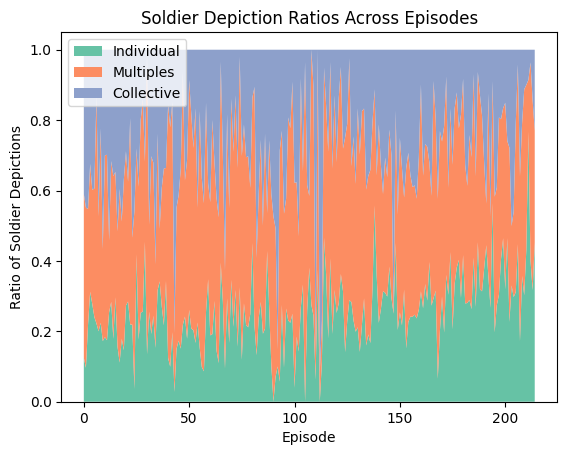

In [20]:
palette = sns.color_palette("Set2")  # 3 colors for the 3 categories
# Sort by episode if needed
episode_stats = episode_stats.sort_values(['year', 'episode'])

plt.stackplot(
    episode_stats.index,  # just a numeric index or time
    episode_stats['individual_ratio'],
    episode_stats['multiples_ratio'],
    episode_stats['collective_ratio'],
    labels=['Individual', 'Multiples', 'Collective'],
    colors=palette
)
plt.legend(loc='upper left')
plt.xlabel("Episode")
plt.ylabel("Ratio of Soldier Depictions")
plt.title("Soldier Depiction Ratios Across Episodes")
plt.show()


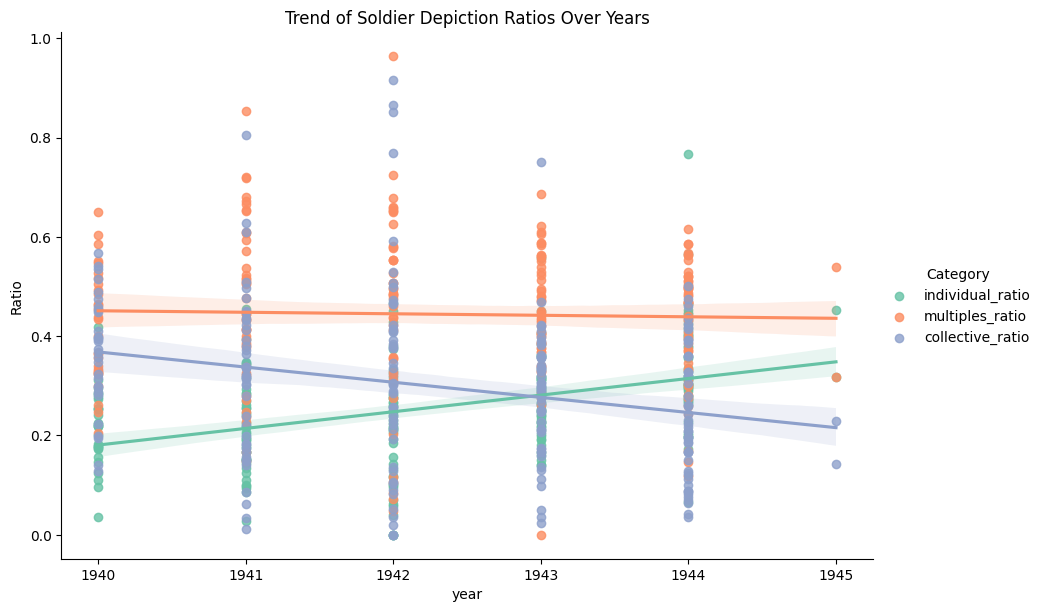

In [19]:
episode_stats_long = episode_stats.melt(
    id_vars=['year', 'episode'],
    value_vars=['individual_ratio', 'multiples_ratio', 'collective_ratio'],
    var_name='Category',
    value_name='Ratio'
)

# Plot trendlines using linear regression
sns.lmplot(
    data=episode_stats_long,
    x='year',
    y='Ratio',
    hue='Category',
    palette='Set2',
    height=6,
    aspect=1.5,
    ci=95  # 95% confidence interval
)
plt.title("Trend of Soldier Depiction Ratios Over Years")
plt.show()

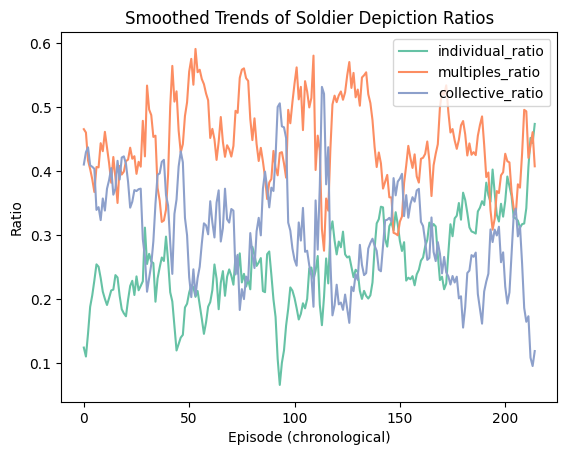

In [21]:
episode_stats_sorted = episode_stats.sort_values(['year', 'episode'])

for category, color in zip(['individual_ratio','multiples_ratio','collective_ratio'], palette):
    smoothed = episode_stats_sorted[category].rolling(window=5, min_periods=1).mean()
    plt.plot(smoothed, label=category, color=color)

plt.legend()
plt.xlabel("Episode (chronological)")
plt.ylabel("Ratio")
plt.title("Smoothed Trends of Soldier Depiction Ratios")
plt.show()
